<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/Lecture-AI_programming/09-autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autograd

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35

In [2]:
import numpy as np
import torch

from IPython.display import display
import torchviz

In [3]:
for c in [np, torch]:
  print(c.__name__, c.__version__)

numpy 1.25.2
torch 2.2.1+cu121


## 1. `requires_grad`를 True로 설정
- tensor 연산 추적, 자동으로 gradient 계산

In [4]:
x_np = np.arange(-1, 1, 0.5)

x = torch.tensor(x_np, dtype=torch.float32)
x.requires_grad = True

display(x)

tensor([-1.0000, -0.5000,  0.0000,  0.5000], requires_grad=True)

## Autograd 관련 attributes

### x.is_leaf
- 계산 그래프에서 “leaf node"인지 여부를 나타냄.
- leaf node는 다른 tensor를 기반으로하는 어떤 연산을 통해 생성되지 않은 tensor로서 직접적으로 생성한 것들임.
- 만약 tensor 가 다른 tensor로부터 어떤 연산을 통해 생성되었다면, is_leaf 속성은 False임.

### x.grad_fn
- 텐서가 다른 텐서들의 연산을 통해 생성된 경우(=leaf node가 아닌 경우),
- grad_fn은 해당 연산을 나타내며,
- 이 정보를 통해 back-propagation 에서 gradient를 계산할 때 어떤 연산을 통해 편미분을 계산하는지 알 수 있음.

### x.grad
- tensor 인스턴스 x 에 대해 수행된 마지막 .backward() 연산으로부터 계산된 gradient가 저장됨.
- x의 requires_grad = True일 때,
  - PyTorch는 x에 대한 모든 연산을 추적하며
  - .backward()가 호출될 때 자동으로 gradient를 계산하여 x.grad에 저장
- 만약 x가 scalar가 아닌 경우, .backward() 호출 시 gradient의 shape를 지정하는 argument를 전달해야함
(.backward()를 호출하는 tensor와 같은 shape 이며 각 요소로 scalar 1을 가지는 tensor 인스턴스가 주로 argument로 사용됨.)

## 2. tensor 인스턴스에 대한 연산 기재

In [5]:
y = 3 * x + 10

display(y)

tensor([ 7.0000,  8.5000, 10.0000, 11.5000], grad_fn=<AddBackward0>)

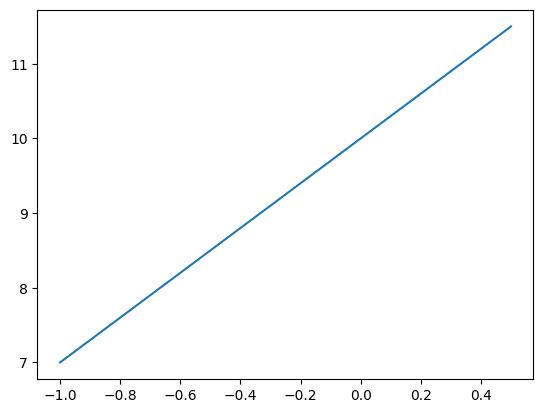

In [6]:
import matplotlib.pyplot as plt

# plt.plot(x, y) # requires_grad=True인 경우 not working (.detach 필요.)
plt.plot(x.detach().numpy(), y.detach().numpy()) # requires_grad=True인 경우 not working

- 1번 과정에서 requires_grad=True인 tensor 인스턴스에 연결된 모든 tensor 인스턴스도 다 requires_grad=True 임.
- 맨 처음 requires_grad=True 로 지정한 tensor 인스턴스는 is_leaf는 True로 설정되고, 이후 해당 인스턴스에 연결되는 Tensor들은 is_leaf가 False 임.
- 이들 연결된 tensor들의 grad_fn 에 Backward function이 할당됨

leaf node 가 아닌 다른 tensor 와 연산으로 만들어진 tensor 인스턴스에 대해
Gradient를 구하고 싶을때는 해당 tensor 인스턴스의 메서드 .retain_grad()를
.backward() 호출 전에 호출하면 됨: <br>
이를 통해 해당 tensor 인스턴스의 gradient를 "유지"하게 됨.



## 3. Back-propagation 수행

backpropagation이 시작되는 loss function 의 결과 Tensor 인스턴스 ( b )에서
backward() 메서드를 수행하여 gradient를 계산하고,

computational graph의 leaf node의 attribute 인 .grad 에 계산된 gradient를 accumulate 시킴.

때문에 .backward()가 호출될 때 넘겨지는 argument는
"호출에 사용되는 tensor 인스턴스"와 같은 shape이면서 값은 scalar 1을 가지는 tensor 인스턴스 이어야 함.
아니면 .backward() 메서드를 호출하는 tensor 인스턴스가 scalar 여야 한다.


argument로 retain_graph=True 를 넘겨줄 경우, .backward()를 여러차례 호출이 가능함.

해당 argument를 True로 설정하지 않으면,
.backward() 가 gradient를 계산하면서, forward phase에서 구해진 intermediate value들을 모두 free 시켜서
이후 forward phase 수행 없이 곧바로 다시 .backward()를 호출할 경우 runtime error가 발생함.
.backward()를 여러차례 호출할 경우, leaf node의 grad에 계산된 gradient가 accumulated 되는 것을 쉽게 확인 가능함.

(모델의 파라메터를 제대로 갱신하려면, 꼭 leaf node의 grad의 초기화가 필요함.)

In [7]:
y.backward(torch.ones_like(y))

# 다시 backward를 하기 전 꼭 초기화할것.
# 안하면 누적되기 때문임.
# 우선 누적되는 여부를 보기 위해 주석처리가 되어 있음.
# x.grad.zero_() #inplace op.

## 4. Gradient 확인

In [8]:
display(x.grad)

tensor([3., 3., 3., 3.])

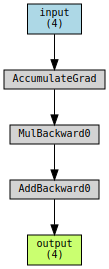

In [10]:
cg = torchviz.make_dot(y, params={"input":x, "output":y})

cg.render("graph", view=True) # save pdf
display(cg) # jupyter note에서 확인.

In [11]:

# x.grad를 초기화하지 않고 다른 loss에서의 grad 계산을 수행시.
y2 = 2*x
y2.backward(torch.ones_like(y2))

display(x.grad) # 앞서의 3과 현재의 2가 더해져 5로 나옴.


tensor([5., 5., 5., 5.])

## 초기화 관련하여
일반적으로,

Training 과정 중 "한 번의 iteration (단일 batch에 대해)"이 끝난 후에는 grad 를 0으로 초기화해야 함.

grad 를 초기화하지 않으면, 각 batch에 대한 grad가 이전 batch의 grad에 더해져 누적됨.
이후 (gradient decent 기반의 ) optimizer를 통해 누적된 grad 를 기반으로 model의 parameters가 update되며,
이는 잘못된 parameter update를 의미하고, 결국 제대로 학습이 이루어지지 못하는 결과로 이어짐.
즉, 한 epoch가 여러 batch의 iteration으로 이루어질 때,

각 배치 처리(=하나의 iteration) 후에 구해진 grad 들을 0으로 초기화하지 않으면
첫 번째 batch 에 대한 grad 계산이 두 번째 batch 의 grad 에 영향을 주고,
이는 모든 이어지는 batch들에 마찬가지로 영향을 줌.
결국 한 epoch에서의 gradient가 제대로 반영되지 못하게 된다.
이를 막기위해 대부분의 training loop 에서는

적절한 위치에 x.grad.zero_() (또는 optimizer.zero_grad())를 호출하여
gradient를 초기화함.

In [ ]:
# 예제 코드
for data, target in dataset:
    optimizer.zero_grad() # model의 모든 parameters의 grad를 0으로 초기화
    output = model(data)
    loss = loss_function(output, target)
    loss.backward()   # back-propagation을 통해 gradient 계산
    optimizer.step()  # 계산된 gradient를 통해 model의 parameters 갱신 (or 수정).